### Preamble

In [ ]:
%load_ext autoreload
%autoreload 2

# for storing .pkl table data, .tex and preview pdf
file_prefix = 'results/milp-benchmark'

# Mixed-integer linear programming benchmark

We measure the average running time of the MILP-solver for different selections of cutting planes. To prevent running times blowing up, we use a fixed time-out for each instance. For this analysis, we do not keep track of the optimal schedule. When we need optimal schedules for the imitation learning, we compute them with larger time bound.

## Experiment specification

In [2]:
from single.basics import generate_instance, uniform, bimodal_exponential

import pandas as pd
import numpy as np
import time 
from datetime import datetime, timedelta
from itertools import product

# static parameters
R = 2
# F = bimodal_exponential(p=0.1, s1=0.1, s2= 5.6)
F = uniform()
number_of_instances = 1
timelimit = 10

cut_names = {
    1 : 'transitive',
    2 : 'conjunctive',
    3 : 'disjunctive',
}

# variables
ns = [20, 25]
cuts_combinations = [[], [1]]#, [2], [3]]

results = pd.DataFrame(product(ns, cuts_combinations), columns=['vehicles_per_route', 'cuts'])
# write full cut combination names
def cut_name(cuts):
    if not cuts: return 'vanilla'
    return ', '.join([cut_names[x] for x in cuts])
results['cuts_str'] = results['cuts'].apply(cut_name)

# generate instance sets, one for each size
instance_sets = { n: [generate_instance(F, n, R) for _ in range(number_of_instances)] for n in ns }

Try to find a rough bound on the total time required for this experiment.

In [3]:
time_bound = timedelta(seconds=len(ns) * len(cuts_combinations) * number_of_instances * timelimit)
print(f"runtime upper bound: {time_bound}")

runtime upper bound: 0:00:40


In [4]:
results

,vehicles_per_route,cuts,cuts_str
0,20,[],vanilla
1,20,[1],transitive
2,25,[],vanilla
3,25,[1],transitive


## Measure running times

Run the analysis, this may take a while...

In [ ]:
started = datetime.now()
print(f"started: {started.strftime('%H:%M:%S')}")
end = started + time_bound
print(f"done before: {end.strftime('%H:%M:%S')}")

for i, row in results.iterrows():
    instances = instance_sets[row['vehicles_per_route']]
    times = []
    for instance in instances:
        start = time.time()
        instance.solve(cutting_planes=row['cuts'], timelimit=timelimit)
        times.append(time.time() - start)
    results.loc[i, 'time'] = np.array(times).mean()
    results.loc[i, 'std'] = np.array(times).std()

    # checkpoint
    results.to_pickle(f'{file_prefix}.pkl')

started: 01:45:02
done before: 01:45:42


## Reporting

### Table wrangling

Pivot the data and group by cuts.

In [6]:
pivoted = results.pivot(index='vehicles_per_route', columns='cuts_str',  values=['time', 'std'])
pivoted = pivoted.swaplevel(axis=1).sort_index(axis=1)
pivoted

cuts_str           transitive            vanilla           
                          std       time     std       time
vehicles_per_route                                         
20                        0.0  10.028316     0.0  10.027777
25                        0.0  10.051305     0.0  10.024738

Renaming and number formatting. Highlight the lowest running time in each row.

In [ ]:
from single.util import format_duration

table = pivoted.copy()

# convert to gaps strings
# 2-leveled columns, so apply formatting at every columns,
# e.g. (PPO1, gap), (PPO2, gap), separately
time_cols = table.columns[table.columns.isin(['time'], 1)]
table = table.astype({ col: str for col in time_cols })

def bold_min_sublevel(row):
    new_row = row.copy()
    cols_x = row.index.get_level_values(1) == 'time'
    # find min among these columns
    min_val = row[cols_x].astype(float).min()
    # apply bold only to min in that sublevel
    new_row[cols_x] = [
        f"\\textbf{{{format_duration(float(v))}}}" if float(v)==min_val \
            else f"{format_duration(float(v))}" for v in row[cols_x]]
    return new_row

# hightlight min gap, in each row
table = table.apply(bold_min_sublevel, axis=1)

# further renaming to taste
table.columns.names = ["cuts", "measurement"]
table.index.rename(r'n', inplace=True)

table

cuts_str           transitive        vanilla                
                          std   time     std            time
vehicles_per_route                                          
20                        0.0  (10s)     0.0  \textbf{(10s)}
25                        0.0  (10s)     0.0  \textbf{(10s)}

### LaTeX table export

Export the table to LaTeX, for inclusing in report.

In [10]:
# latex \begin{table}{...} format
column_format = 'c|cc|cc|cc|cc'
latex_table = table.to_latex(multirow=True, column_format=column_format, multicolumn_format='c',
                               escape=False, float_format="%.2f",
                               caption="Performance Table")
print(latex_table)

\begin{table}
\caption{Performance Table}
\begin{tabular}{c|cc|cc|cc|cc}
\toprule
cuts & \multicolumn{2}{c}{transitive} & \multicolumn{2}{c}{vanilla} \\
measurement & std & time & std & time \\
n &  &  &  &  \\
\midrule
20 & 0.00 & (10s) & 0.00 & \textbf{(10s)} \\
25 & 0.00 & (10s) & 0.00 & \textbf{(10s)} \\
\bottomrule
\end{tabular}
\end{table}



In [ ]:
import re

# some further automated formatting (just search/replace)
# 1. remove all \cline
latex_table = re.sub(r'\\cline\{.*?\}\s*\n?', '', latex_table)
# 2. remove \toprule
latex_table = re.sub(r'\\toprule\s*\n?', '', latex_table)
# 3. replace \bottomrule with \midrule
latex_table = re.sub(r'\\bottomrule\s*\n?', '\\\\midrule\n', latex_table)
# 4. TODO: extract tabular
# latex_table = re.sub()
match = re.search(r"\\begin\{tabular.*?\\end\{tabular\}", latex_table, re.DOTALL)
latex_table = match.group(0)

# write complete latex template for preview
# (with timestamp)
from datetime import datetime
now = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
date_line = f"\\noindent\\textit{{Compiled on: {now}}}\\\\\n"
latex = f"""
\\documentclass{{article}}
\\usepackage{{booktabs}}
\\usepackage{{multirow}}
\\usepackage{{siunitx}}
\\usepackage[skip=10pt]{{caption}}
\\usepackage[margin=1cm]{{geometry}}
\\begin{{document}}
\\begin{{table}}
{latex_table}
\\end{{table}}
{date_line}
\\end{{document}}"""

with open(file_prefix + '.preview.tex', 'w') as f:
    f.write(latex)
!tectonic {file_prefix + '.preview.tex'}

Running TeX ...
Rerunning TeX because "milp-benchmark.preview.aux" changed ...
Running xdvipdfmx ...
Writing `milp-benchmark.preview.pdf` (9.42 KiB)
Skipped writing 1 intermediate files (use --keep-intermediates to keep them)


In [12]:
# write only table, for direct use in report
with open(file_prefix + '.tex', 'w') as f:
    f.write(latex_table)

### Plot


These could be incredibly insightful in terms of seeing the scaling. However, we need to keep the number of lines per plot lower, otherwise it is very difficult to read.

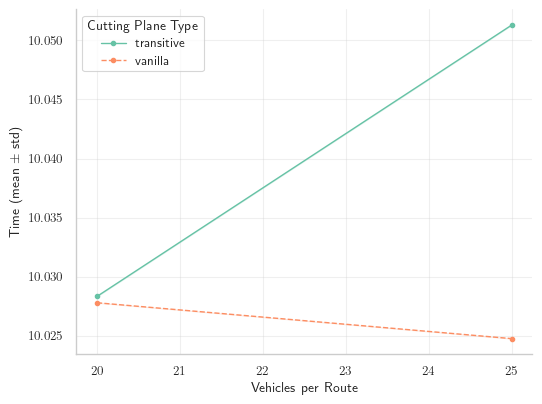

In [13]:
from util import get_figsize
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("paper")  # or "talk" for presentations

fig, ax = plt.subplots(figsize=get_figsize())
line_styles = ['-', '--', '-.', ':']

df = pivoted
categories = df.columns.get_level_values(0).unique()
colors = plt.cm.Set2(range(len(categories)))

for category, style, color in zip(categories, line_styles, colors):
    mean = df[category]['time']
    std = df[category]['std']

    ax.plot(df.index, mean, linestyle=style, marker='o', 
            linewidth=1, markersize=3,
            color=color, label=category)

    # shaded region for std: clip lower bound at 0
    lower_bound = mean - std
    upper_bound = mean + std

    ax.fill_between(df.index, lower_bound, upper_bound, alpha=0.2, color=color)

ax.set_xlabel(r'Vehicles per Route')
ax.set_ylabel(r'Time (mean $\pm$ std)')
ax.legend(title=r'Cutting Plane Type')

sns.despine()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('./figures/milp-benchmark.pdf');
plt.show();